## Анализ мобильной игры "Космические братья"

Цель исследования - проанализировать действия игроков на первом уровне игры, а также их источники перехода в игру.

В процессе мы составили профили пользователей и проанализировали различные действия в игре (способ завершения уровня, количество построенных зданий). Также проведен анализ рекламных источников, рассчитан САС и количество привлеченных игроков. При помощи статистического теста проверены 2 гипотезы.

[Ссылка на дашборд](https://public.tableau.com/shared/45BF9H37M?:display_count=n&:origin=viz_share_link)
 
[Ссылка на презентацию](https://drive.google.com/file/d/1JsIX-iPggDhkBXNVwRcsfUYNfPwFdYze/view?usp=share_link)
 

### Загрузка и изучение данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
from datetime import timedelta


import warnings
warnings.filterwarnings("ignore")

In [2]:
# параметры визуализации
sns.set(
    font_scale =2,
    style      ='whitegrid',
    rc         ={'figure.figsize':(20,10)},
)

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', '{:,.2f}'.format)

colors = sns.color_palette('muted')

In [3]:
try:
    actions = pd.read_csv('game_actions.csv')
    user = pd.read_csv('user_source.csv')
    ad_cost = pd.read_csv('ad_costs.csv')
except:
    actions = pd.read_csv('/datasets/game_actions.csv')
    user = pd.read_csv('/datasets/user_source.csv')
    ad_cost = pd.read_csv('/datasets/ad_costs.csv')

#### Датасет с логами игры

In [4]:
# Проверка, что все корректно отображается
actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [5]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


#### Датасет с пользователями

In [6]:
# Проверка, что все корректно отображается
user.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [7]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


#### Датасет с рекламными источниками

In [8]:
# Проверка, что все корректно отображается
ad_cost.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


In [9]:
ad_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


**Вывод:**

Для анализа использются 3 датасета:

1. Основной датасет actions (5 столбцов, 135640 строк) содержит данные пользователей приложения, которые присоединились в игру с 4 по 10 мая 2020 года. Каждая строка представляет из себя действие пользователя в игре, будь то строительство здания, либо завершение уровня.

2. Датасет user (2 стобца, 13576 строк) содержит перечень уникальных идентификаторов пользователей и рекламный источник, с которого пользователи пришел

3. Датасет ad_cost (2 столбца, 28 строк) содержит расходы компании на рекламные источники с 3 по 9 мая 2020 года.

### Предобработка данных

#### Изменение типов данных

In [10]:
# Перевод столбцов с датами в нужный формат
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])

ad_cost['day'] = pd.to_datetime(ad_cost['day'])

#### Поиск дубликатов

In [11]:
# Поиск явных дубликатов
print(actions.duplicated().sum())
print(user.duplicated().sum())
print(ad_cost.duplicated().sum())

1
0
0


In [12]:
# Дополнительно проверяем идентификатор юзера на уникальность
user['user_id'].duplicated().sum()

0

In [13]:
# Удаляем явные дубликаты
actions.drop_duplicates()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


#### Аализ пропущенных значений

In [14]:
# выводим кол-во пропущенных значений
pd.DataFrame(actions.isna().sum()).style.background_gradient('coolwarm')

,0
event_datetime,0
event,0
building_type,7683
user_id,0
project_type,133774


Пропущенные значения имеются только в датасете с логами и они обоснованы механикой игры
* Значение в столбец project_type будет добавлено только если в столбце event находится значение project;
* Значение в столбец building_type будет добавлено только если в столбце event находится значение building.

Необходимо проверить, что это логика соблюдается во всем датасете

In [15]:
# Значения столбца event при заполненном project_type
print(actions.query('project_type.notnull()')['event'].value_counts())
print(actions.query('event == "project"')['event'].count())

project    1866
Name: event, dtype: int64
1866


In [16]:
# Значения столбца event при заполненном building_type
print(actions.query('building_type.notnull()')['event'].value_counts())
print(actions.query('event == "building"')['event'].count())

building    127957
Name: event, dtype: int64
127957


Логика соблюдена, в заполнении пропущенных значений нет необходимости.

**Вывод:**

В процесее предобработки данных были заменены столбцы с данными на нужный формат, проверены и удалены дубликаты.
Пропуски содержит только датасет actions, однако они обусловлены условием сбора данных и не требуют заполнения.


### Исследовательский анализ данных

#### Составление профилей пользователей

In [17]:
print('Кол-во уникальных пользователей в игровых логах:', actions['user_id'].nunique())
print('Кол-во пользователей в датасете с пользователями:', user['user_id'].count())

Кол-во уникальных пользователей в игровых логах: 13576
Кол-во пользователей в датасете с пользователями: 13576


Количество уникальных пользователей в двух датасетах совпадают - хороший знак.

In [18]:
# Создание нового столбца с датой
actions['dt'] = actions['event_datetime'].dt.date

In [19]:
# Составим профили пользователей
profiles = (
    actions.sort_values(by=['user_id', 'dt'])
    .groupby('user_id', as_index=False)
    .agg({'dt': 'first', 'building_type': 'count'})
    .rename(columns={'building_type': 'total_buildings'})
)


profiles.head()

,user_id,dt,total_buildings
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,4
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,8
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,12


В результате получаем список пользователей, дату начала игры и количество построенных зданий. Далее для анализа нам необходимо определить статус завершения уровня и длительность его прохождения, а также для каждого пользователя определить рекламный источник.

#### Анализ способов завершения уровня

Для начала необходимо выяснить, какие пользователи завершили уровень и каким образом.
Для этого создадим сводную табличку,в которой посчитаем количество каждого значения из столбца event

In [20]:
actions_by_users = actions\
.sort_values(by=['user_id', 'dt'])\
.pivot_table(index='user_id', columns='event', values='dt', aggfunc=['count', 'last'])\
.reset_index()

actions_by_users.columns = [
    'user_id', 
    'total_buildings', 
    'finished_stage_1', 
    'project', 
    'building_lastdt', 
    'finished_stage_1_dt', 
    'project_dt'
]

actions_by_users.head()

,user_id,total_buildings,finished_stage_1,project,building_lastdt,finished_stage_1_dt,project_dt
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.00,NaN,NaN,2020-05-20,NaN,NaN
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.00,NaN,NaN,2020-05-18,NaN,NaN
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.00,NaN,NaN,2020-05-14,NaN,NaN
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.00,1.00,NaN,2020-05-12,2020-05-12,NaN
4,002f508f-67b6-479f-814b-b05f00d4e995,12.00,NaN,NaN,2020-05-22,NaN,NaN


Логично, что в столбцах finished_stage_1 и project может быть значение либо 1 (пользователь совершил это действие), либо NaN (в логах пользователя данного действия нет). Проверим

In [21]:
print(actions_by_users['finished_stage_1'].value_counts())

print(actions_by_users['project'].value_counts())

1.00    5817
Name: finished_stage_1, dtype: int64
1.00    1866
Name: project, dtype: int64


Согласно механике игры, пройти уровень можно 2-ся способами: реализовать проект (обозначим как PvE) или победить врага (обозначим как PvP). Методика определения способа прохождения уровня следующая:

* У пользователя в  логах есть событие project (реализация проекта) - пользователь прошел уровень PvE сопосбом;
* У пользователя в логах отсутствует событие project(реализация проекта), но имеется событие finished_stage_1 - пользователь прошел уровень PvP способом;
* У пользователя в логах отсутствуют оба события - пользователь не завершил уровень.

В таблицу actions_by_users введем новый столбец win_way, в которой укажем статус и способ прохождения уровня.

In [22]:
# Вспомогательные столбцы
actions_by_users['level_complete'] = actions_by_users['finished_stage_1'].apply(lambda x: True if x==1 else False)
actions_by_users['project_complete'] = actions_by_users['project'].apply(lambda x: True if x==1 else False)

# Функция для проставления категории
def win_way(row):
    if row['project_complete'] == True and row['level_complete'] == True:
        return 'PvE'
    elif row['project_complete'] == False and row['level_complete'] == True:
        return 'PvP'
    return 'Not Completed'


# Применяем функцию
actions_by_users['win_way'] = actions_by_users.apply(win_way, axis=1)

actions_by_users.head()

,user_id,total_buildings,finished_stage_1,project,building_lastdt,finished_stage_1_dt,project_dt,level_complete,project_complete,win_way
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.00,NaN,NaN,2020-05-20,NaN,NaN,False,False,Not Completed
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.00,NaN,NaN,2020-05-18,NaN,NaN,False,False,Not Completed
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.00,NaN,NaN,2020-05-14,NaN,NaN,False,False,Not Completed
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.00,1.00,NaN,2020-05-12,2020-05-12,NaN,True,False,PvP
4,002f508f-67b6-479f-814b-b05f00d4e995,12.00,NaN,NaN,2020-05-22,NaN,NaN,False,False,Not Completed


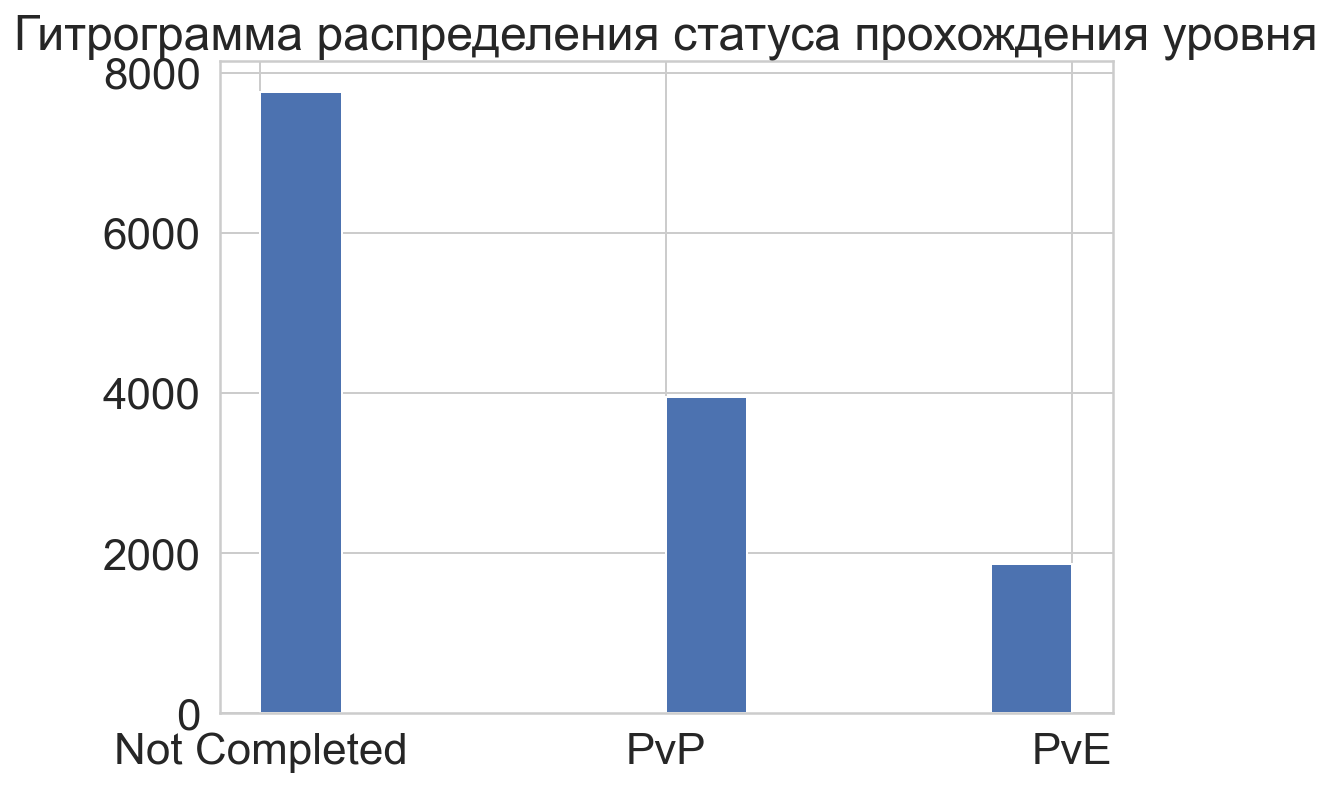

In [23]:
plt.figure(figsize=(8, 6))

# Рисуем гистограмму
actions_by_users['win_way'].hist()

plt.title('Гитрограмма распределения статуса прохождения уровня')
plt.show();

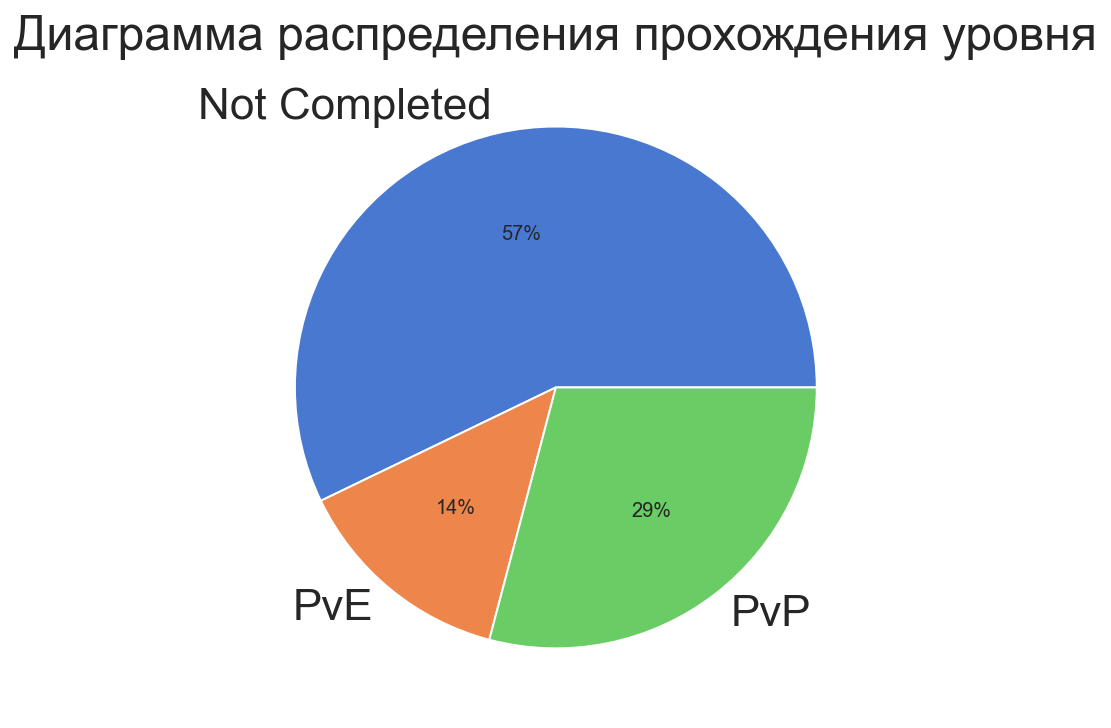

In [24]:
# Подготовка данных
data = actions_by_users.groupby('win_way', as_index=False).agg({'user_id':'count'})

plt.figure(figsize=(10, 6))

# Построение графика
plt.pie(data=data, x='user_id', labels='win_way', colors = colors, autopct='%.0f%%')

plt.title('Диаграмма распределения прохождения уровня')
plt.show();

Увы, большая часть пользователей так и не осилила первый уровень игры. Среди прошедших наиболее популярный способ прохождения - победа над врагом (PvP).

#### Длительность прохождения уровня в игре

Для того, чтобы определить длительность прохождения уровня, вначале для каждого пользователя, завершившего уровень, определеляем дату завершения, а для длительности отнимем от даты завершения дату начала игры.

In [25]:
# Функция для столбца с датой завешения уровня
def win_date(row):
    if row['win_way'] == 'PvE' or row['win_way'] == 'PvP':
        return row['finished_stage_1_dt']
    return 

# Используем функцию
actions_by_users['win_dt'] = actions_by_users.apply(win_date, axis=1)

# Удаляем ненужные столбцы
actions_by_users = actions_by_users[['user_id', 'win_way', 'win_dt']]

actions_by_users.head()

,user_id,win_way,win_dt
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,Not Completed,None
1,00151b4f-ba38-44a8-a650-d7cf130a0105,Not Completed,None
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,Not Completed,None
3,001d39dc-366c-4021-9604-6a3b9ff01e25,PvP,2020-05-12
4,002f508f-67b6-479f-814b-b05f00d4e995,Not Completed,None


У пользователей, которые не прошли уровень, в столбце с датой завершения win_dt будет пропуск.

In [26]:
# В профили пользователей добавляем информацию с датой и способом завершения уровня
profiles = profiles.merge(actions_by_users, on='user_id')

In [27]:
# Добавляем столбец с длительностью прохождения уровня
profiles['duration'] = profiles['win_dt'] - profiles['dt']
print(profiles.info())
profiles['duration'] = profiles['duration'].astype('timedelta64[D]')

profiles.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13576 entries, 0 to 13575
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   user_id          13576 non-null  object         
 1   dt               13576 non-null  object         
 2   total_buildings  13576 non-null  int64          
 3   win_way          13576 non-null  object         
 4   win_dt           5817 non-null   object         
 5   duration         5817 non-null   timedelta64[ns]
dtypes: int64(1), object(4), timedelta64[ns](1)
memory usage: 742.4+ KB
None


,user_id,dt,total_buildings,win_way,win_dt,duration
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,13,Not Completed,None,NaN
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,9,Not Completed,None,NaN
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,4,Not Completed,None,NaN
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,8,PvP,2020-05-12,7.00
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,12,Not Completed,None,NaN


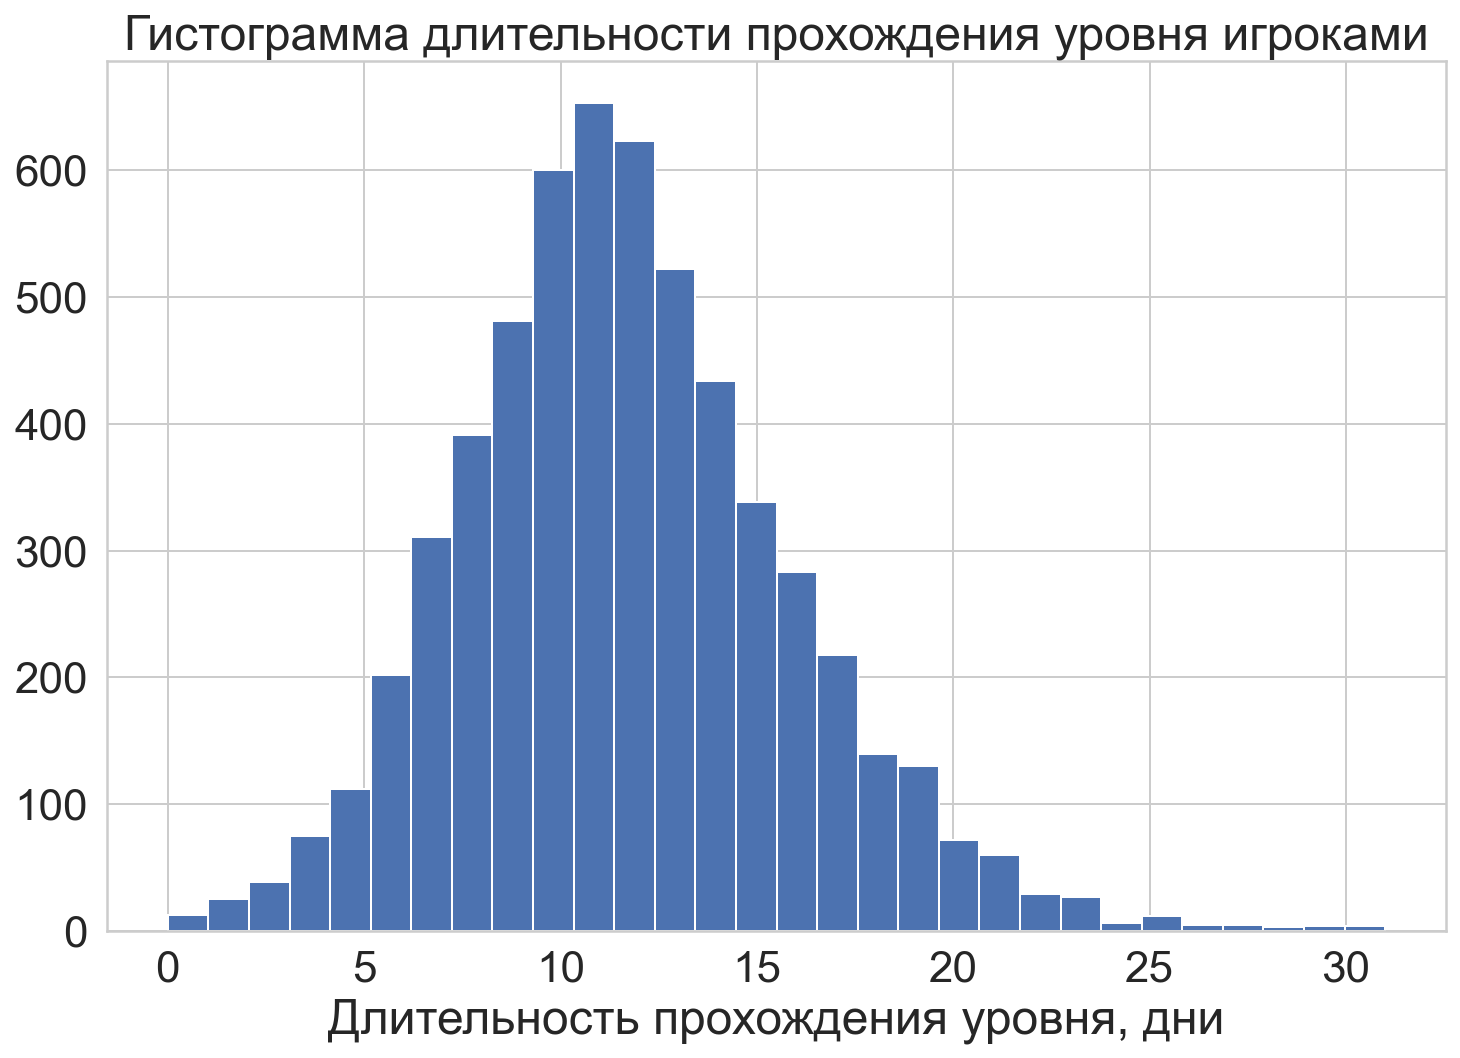

In [158]:
profiles['duration'].hist(bins=30, figsize=(12,8))

plt.title('Гистограмма длительности прохождения уровня игроками')
plt.xlabel('Длительность прохождения уровня, дни');

In [159]:
profiles['duration'].describe()

count   5,817.00
mean       11.81
std         4.08
min         0.00
25%         9.00
50%        12.00
75%        14.00
max        31.00
Name: duration, dtype: float64

В среднем пользователям требуется 11 дней, чтобы завершить уровень.

Теперь выясним, влияет ли способ завершения уровня на длительность его прохождения.

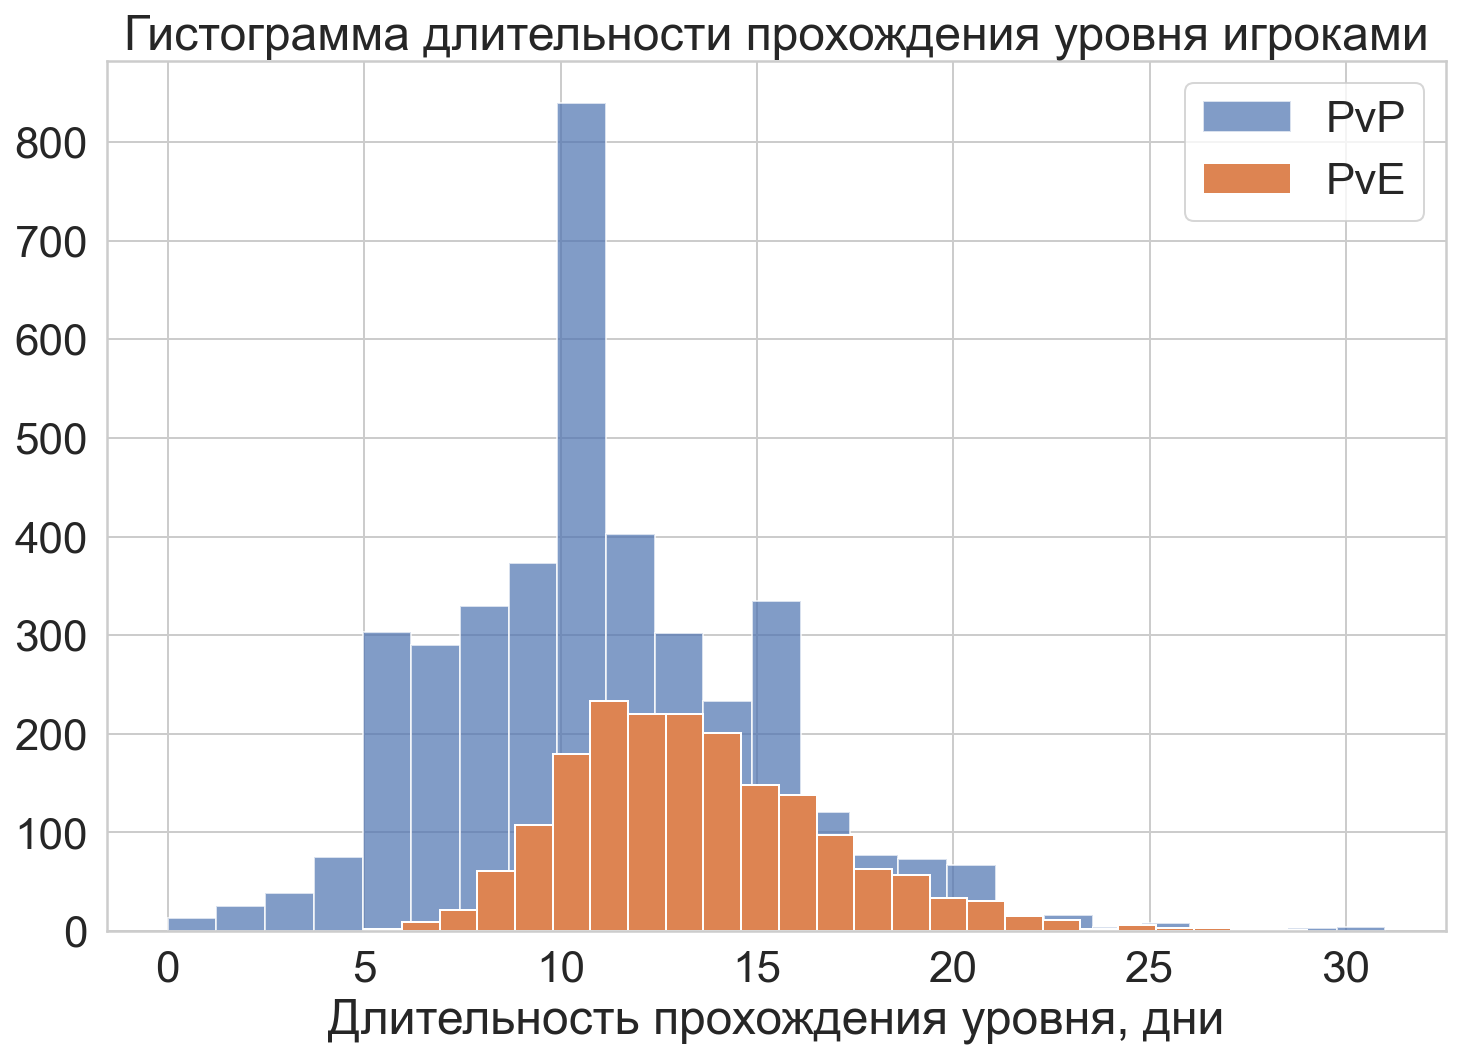

In [160]:
hist_1 = profiles.query('win_way == "PvP"')['duration']
hist_2 = profiles.query('win_way == "PvE"')['duration']

plt.figure(figsize=(12, 8))

plt.hist(hist_1, bins=25, alpha=0.7, label='PvP')
plt.hist(hist_2, bins=25, alpha=1, label='PvE')
plt.legend(loc='upper right')
plt.title('Гистограмма длительности прохождения уровня игроками')
plt.xlabel('Длительность прохождения уровня, дни')
plt.show();

PvP игрокам в среднем требуется 11 дней на прохождение уровня. Гистрограмма PvE пользователей немного смещена вправо относительно PvE игроков. Это говорит о том, что на данную стратегию игрокам требуется больше времени.

#### Анализ построенных объектов и игре

Так как перспективная модель монетизации - показ рекламы на экране с выбором типа объекта для постройки, необходимо проанализировать сколько объектов в среднем строит пользователь на уровне.

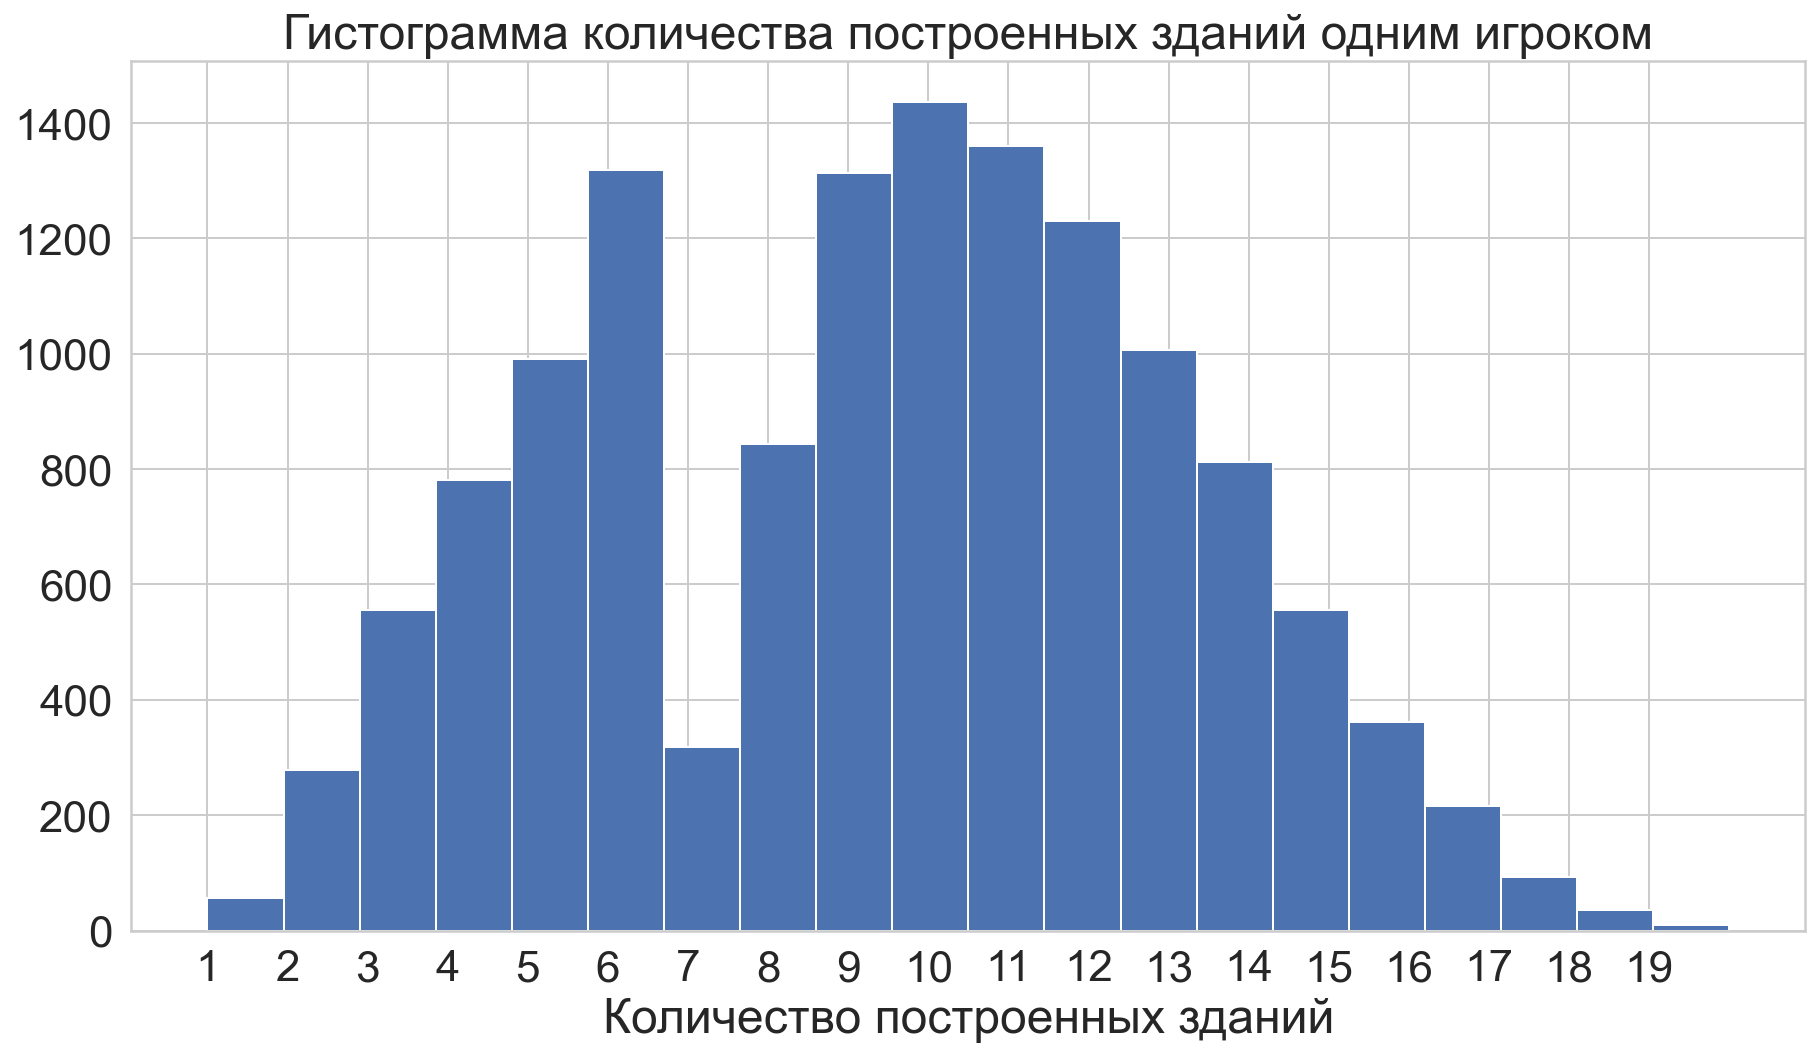

In [161]:
profiles['total_buildings'].hist(bins=20, figsize=(15,8))

plt.xticks(np.arange(1,20))
plt.title('Гистограмма количества построенных зданий одним игроком')
plt.xlabel('Количество построенных зданий');

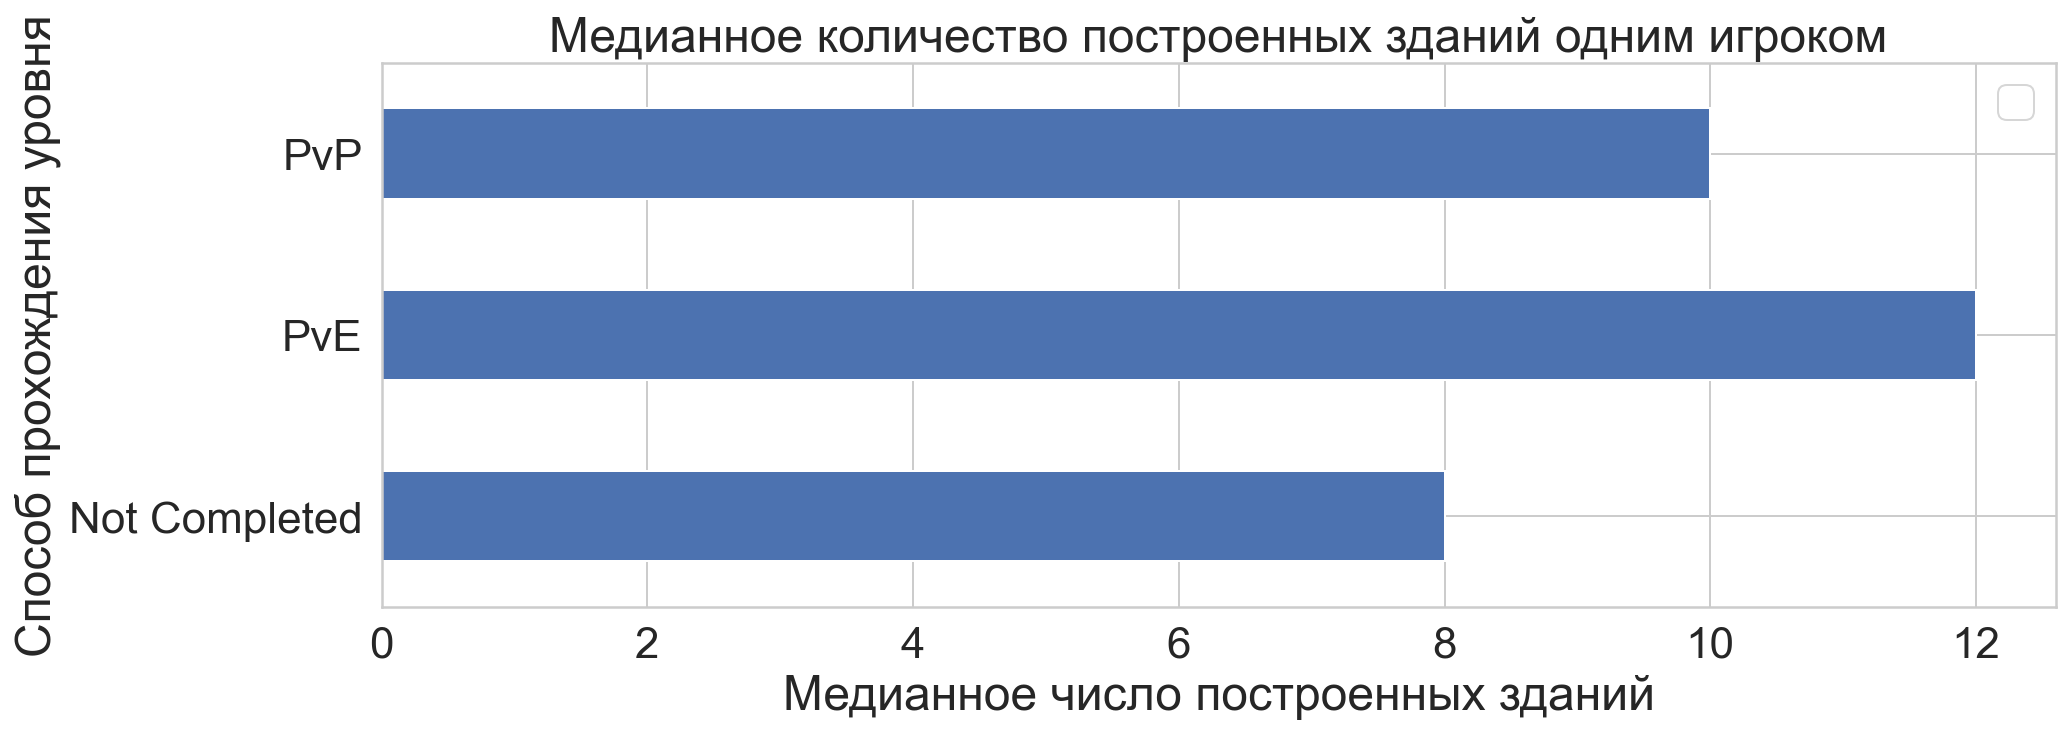

In [162]:
# Подготовка данных
data = (profiles.groupby('win_way', as_index=False)
        .agg({'total_buildings':'median'})
       )

# Построение графика
data.plot(kind='barh', x='win_way', y='total_buildings', figsize=(15,5))

plt.ylabel('Способ прохождения уровня')
plt.xlabel('Медианное число построенных зданий')
plt.title('Медианное количество построенных зданий одним игроком')
plt.legend('')
plt.show();

В среднем, каждый пользователь строит около 10 зданий. Больше всего строят зданий игроки, которые завершили уровень через реализацию проекта (PvE) - 12 зданий.

**Вывод:**

* Из всех игроков (13576 пользователя) большая часть не завершила 1-й уровень (57%). Среди завершивших самый популярный способ прохождения – победа над врагом (PvP). Им воспользовались 3951 (29%) игрок. Путем реализации проекта (PvE) уровень завершили 1866 (14%) игроков.

* В среднем игроки тратят 11 дней на прохождение уровня. PvP игроки потратили от 0 до 31 дня. PvE игроки – от 4 до 29 дней.

* Всего за первый уровень игроки строят от 1 до 20 зданий. В среднем на каждого игрока приходится 10 зданий. Больше всего зданий строят игроки, которые завершают уровень путем реализации проекта (PvE)

### Анализ рекламных источников

#### Динамика САС по каналам привлечения пользователя

У нас в распоряжении имеется датасет users, который содежит информацию о рекламном источнике, из которого пришел пользователь. Добавим эту информации в таблицу в профилями.

In [163]:
# Добавляем рекламный источник в таблицу с профилями пользователей
profiles = profiles.merge(user, on='user_id')

profiles['dt'] = pd.to_datetime(profiles['dt'])

По условиям, игрок начинает играть на следующий день после просмотра рекламного объявления, поэтому необходимо ввести новый столбец с датой показа объявления + 1 день для объединения таблиц.

In [164]:
ad_cost['dt'] = ad_cost['day'] + timedelta(days=1)

Теперь найдем стоимость привлечения пользователя.

In [165]:
# считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
new_users = (
    profiles.groupby(['dt', 'source'], as_index=False)
    .agg({'user_id': 'nunique'})
        # столбец с числом пользователей назовём unique_users
    .rename(columns={'user_id': 'unique_users'})
    )

new_users['dt'] = pd.to_datetime(new_users['dt'])

# объединяем траты на рекламу и число привлечённых пользователей по дате и каналу привлечения
ad_cost = ad_cost.merge(new_users, on=['dt', 'source'], how='left')

# делим рекламные расходы на число привлечённых пользователей, получаем расход на одного пользователя (CAC)
ad_cost['acquisition_cost'] = ad_cost['cost'] / ad_cost['unique_users']

# добавим стоимость привлечения в профили
profiles = profiles.merge(
    ad_cost[['dt', 'source', 'acquisition_cost']],
    on=['dt', 'source'],
    how='left'
)

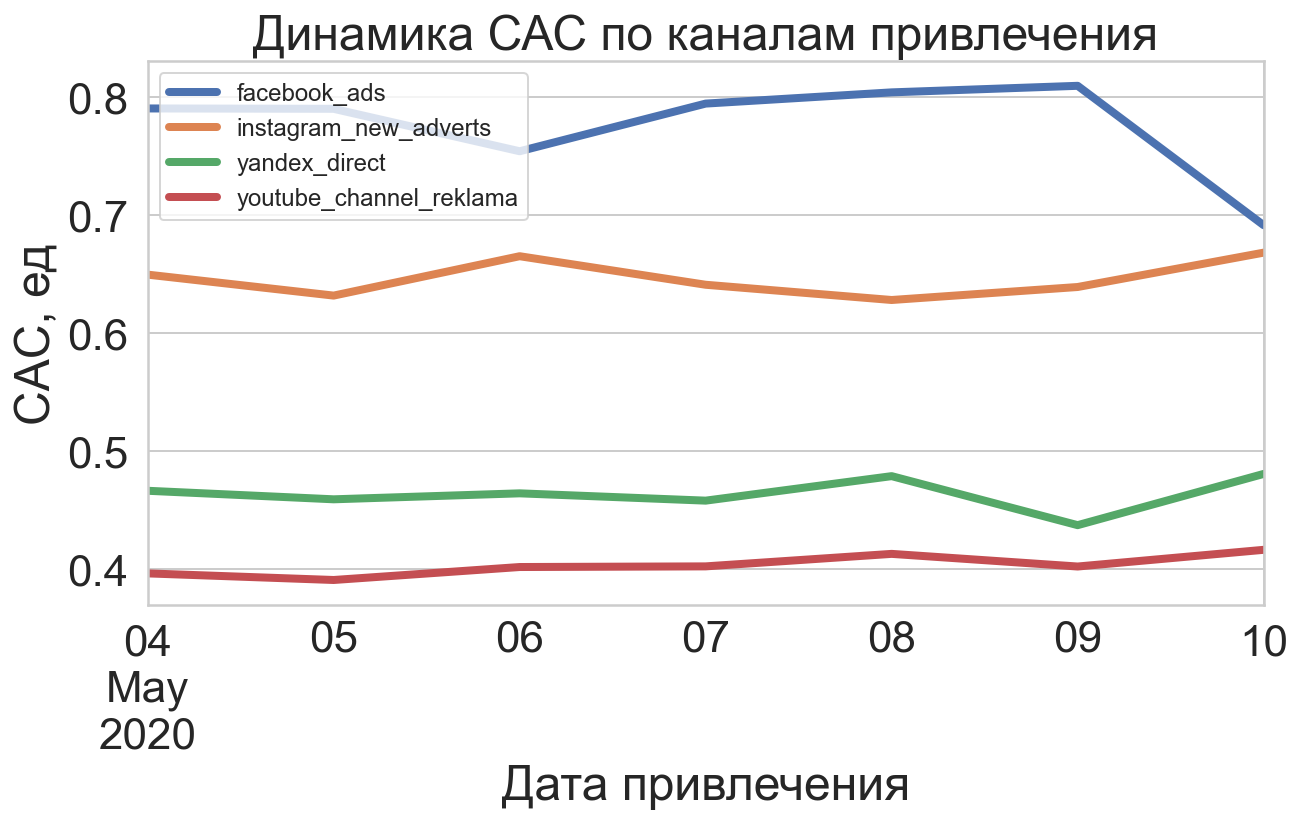

In [166]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='source', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5), linewidth=4)

plt.ylabel('CAC, ед')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [167]:
# Выводим таблицу со средним CAC каждого источника за изучаемый период
print('Среднее значение САС за изучаемый период')
display(profiles.pivot_table(index='source',
                     values='acquisition_cost',
                     aggfunc='mean')
       )

Среднее значение САС за изучаемый период


,acquisition_cost
source,
facebook_ads,0.79
instagram_new_adverts,0.65
yandex_direct,0.46
youtube_channel_reklama,0.40


Самые низкие затраты у источников Youtube и Yandex, самые высокие - источника Facebook.

#### Количество привлеченных пользователей

Определим, сколько игроков привлек каждый рекламный источник.

In [168]:
# Подготовка данных
data = profiles.groupby(['source', 'win_way'], as_index=False)\
.agg({'user_id':'count'})\
.sort_values(by='user_id',ascending=False)

# Построение графика
fig = px.bar(data, x='source', y='user_id', color='win_way')

fig.update_layout(
    title='Кол-во привлеченных игроков рекламными каналами со статусом прохождения уровня',
    title_x=0.95,
    legend_title_text='Статус уровня',
    xaxis_title='Источник трафика',
    yaxis_title = 'Кол-во привлеченных игроков',
    width=850,
    height=600
)

In [169]:
print('Количество привлеченных игроков рекламными источниками')
display(
    profiles.groupby('source', as_index=False)
    .agg({'user_id':'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'total_users'})
       )

Количество привлеченных игроков рекламными источниками


,source,total_users
2,yandex_direct,4817
1,instagram_new_adverts,3347
0,facebook_ads,2726
3,youtube_channel_reklama,2686


Больше всего игроков за исследуемый период привлек рекламный источник Yandex, на втором месте - Instagram. Facebook и Youtube привлекли практически одинаковое количество пользователей.

#### Поведение в игре пользователей из разных рекламных источников

Проверим, отличается ли поведение пользователей, приведенных разными рекламными источниками. Вначале проверим распределение статуса завершения уровня для пользователей из разных рекламных источников. Также, учитывая, что для перспективной модели монетизации необходимым действием игрока является строительство зданий, выведем, сколько зданий строят в среднем игроки, приведенные из разных источников.

                         Диаграмма распределения статуса игроков для каждого рекламного источника                        


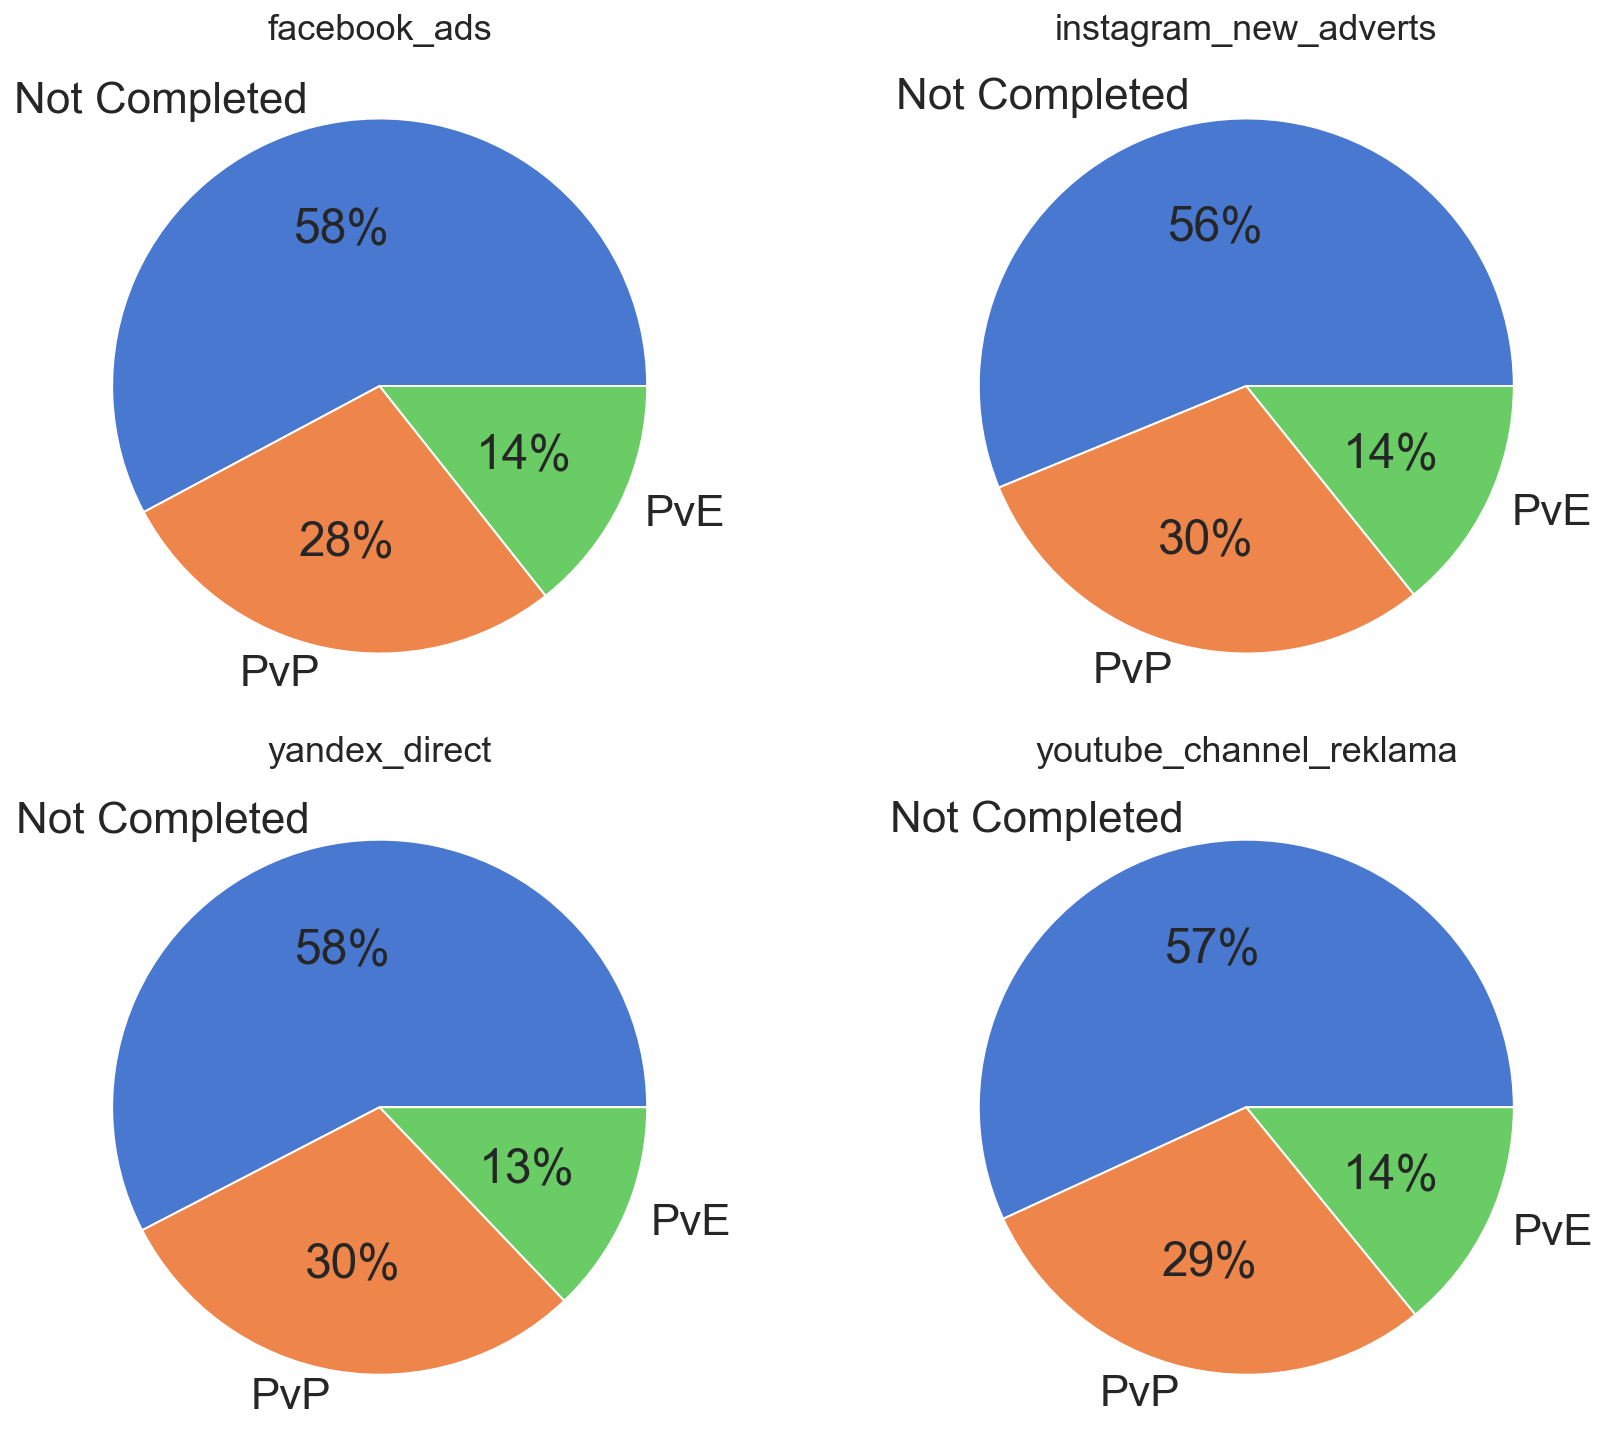

In [170]:
# Предварительные настройки для графиков
fg = plt.figure(figsize=(12,10), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fg)

print('\033[1mДиаграмма распределения статуса игроков для каждого рекламного источника'.center(125))

# Круговая диаграмма 1
source = 'facebook_ads'
df = data.query('source == @source')
fig_ax_1 = fg.add_subplot(gs[0, 0])
ax_1 = plt.pie(data=df, x='user_id', labels='win_way', colors = colors, autopct='%.0f%%')

plt.title(source, fontsize=18)


# Круговая диаграмма 2
source = 'instagram_new_adverts'
df = data.query('source == @source')
fig_ax_2 = fg.add_subplot(gs[0, 1])
ax_2 = plt.pie(data=df, x='user_id', labels='win_way', colors = colors, autopct='%.0f%%')

plt.title(source, fontsize=18)

# Круговая диаграмма 3
source = 'yandex_direct'
df = data.query('source == @source')
fig_ax_2 = fg.add_subplot(gs[1, 0])
ax_2 = plt.pie(data=df, x='user_id', labels='win_way', colors = colors, autopct='%.0f%%')

plt.title(source, fontsize=18)

# Круговая диаграмма 4
source = 'youtube_channel_reklama'
df = data.query('source == @source')
fig_ax_2 = fg.add_subplot(gs[1, 1])
ax_2 = plt.pie(data=df, x='user_id', labels='win_way', colors = colors, autopct='%.0f%%')

plt.title(source, fontsize=18)

plt.show();

In [171]:
# data = profiles.pivot_table(index='source', columns='win_way', values='total_buildings', aggfunc='sum')
data = profiles.groupby('source', as_index=False)\
    .agg({'total_buildings':'mean'})\
    .rename(columns={'total_buildings': 'avg_buildings'})

print('Среднее количество построенных зданий одним игроком в зависимости и источника его привлечения')
display(data)

Среднее количество построенных зданий одним игроком в зависимости и источника его привлечения


,source,avg_buildings
0,facebook_ads,9.59
1,instagram_new_adverts,9.51
2,yandex_direct,9.35
3,youtube_channel_reklama,9.30


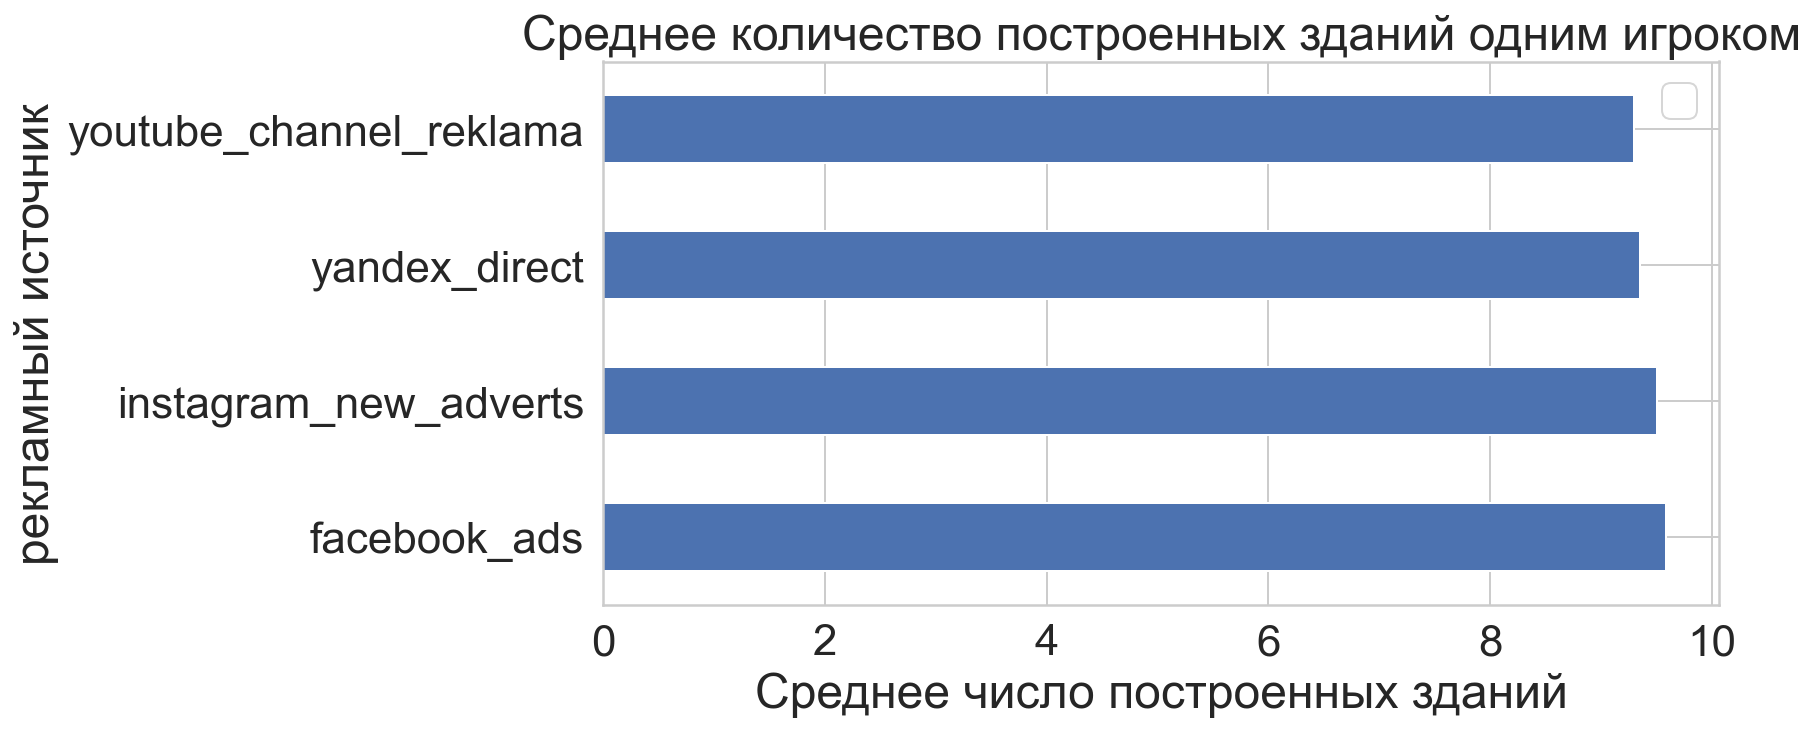

In [172]:
data.plot(kind='barh', x='source', y='avg_buildings', figsize=(10,5))

plt.ylabel('рекламный источник')
plt.xlabel('Среднее число построенных зданий')
plt.title('Среднее количество построенных зданий одним игроком')
plt.legend('')
plt.show()

Графики показывают, что каналы привлекают примерно одинаковых по поведению пользователей. Доли завершения уровня у игроков из разных рекламных источников мало отличается. Как и среднее количество построенных зданий у одного игрока.

**Вывод:**

Всего в датасете представлены 4 рекламных источника: facebook, Instagram, yandex, youtube. Из всех рекламных источников самый низкий САС у youtube (0.4 ед). Затем идут yandex (0.46), Instagram (0.65) и facebook (0.79)

Больше всего пользователей привлек канал yandex (4817 чел). Затем идут Instagram (3347 чел), facebook (2726 чел) и youtube (2686 чел)

Рекламные каналы привлекают примерно одинаковых по поведению игроков.

### Проверка статистических гипотез

#### Первая гипотеза: время прохождения уровня зависит от способа прохождения

Нулевая гипотеза: Среднее время время прохождения уровня ('duration') PvE игроков = среднее время время прохождения уровня ('duration')PvP игроков

Альтернативная гипотеза: Среднее время время прохождения уровня ('duration') PvE игроков ≠ среднее время время прохождения уровня ('duration')PvP игроков

Уровень статистической значимости alpha = 0.05


Используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам scipy.stats.ttest_ind (array1, array2, equal_var)

In [43]:
# вызов метода для проверки гипотезы
results = st.ttest_ind(\
                       profiles.query('win_way == "PvE"')['duration'], \
                       profiles.query('win_way == "PvP"')['duration'], \
                      equal_var=False)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран
print('Статистическая значимость различий среднего времени прохождения:', results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Статистическая значимость различий среднего времени прохождения: 6.5704667556436364e-105
Отвергаем нулевую гипотезу


p-value значительно меньше alpha, значит мы не может утверждать, среднее время прохождения уровня у PvE и PvP игроков одинаковое.

#### Вторая гипотеза: количество построенных зданий у игроков с двух рекламных источников отличается

Нулевая гипотеза: Среднее количество построенных зданий у игроков ('total_buildings'), привлеченных Yandex =  Среднее количество построенных зданий у игроков ('total_building), привлеченных Instagram

Альтернативная гипотеза: Среднее количество построенных зданий у игроков ('total_buildings'), привлеченных Yandex ≠ Среднее количество построенных зданий у игроков ('total_building), привлеченных Instagram

Уровень статистической значимости alpha = 0.05

In [44]:
# вызов метода для проверки гипотезы
results = st.ttest_ind(\
                       profiles.query('source == "yandex_direct"')['total_buildings'], \
                       profiles.query('source == "instagram_new_adverts"')['total_buildings'], \
                      equal_var=False)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран
print('Статистическая значимость различий в количестве построенных зданий:', results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Статистическая значимость различий в количестве построенных зданий: 0.06950918378428955
Не получилось отвергнуть нулевую гипотезу


p-value больше alpha, значит что количество построенных зданий у игроков с двух разных рекламных источников не имеет статистических различий.

### Выводы

При анализе предоставленных датасетов, были сделаны следующие выводы:

**Поведение пользователей:**

Из всех игроков (13576 пользователя) большая часть не завершила 1-й уровень (57%). Среди завершивших самый популярный способ прохождения – победа над врагом (PvP). Им воспользовались 3951 (29%) игрок. Путем реализации проекта (PvE) уровень завершили 1866 (14%) игроков.

В среднем игроки тратят 11 дней на прохождение уровня. PvP игроки потратили от 0 до 31 дня. PvE игроки – от 4 до 29 дней. 

Всего за первый уровень игроки строят от 1 до 20 зданий. В среднем на каждого игрока приходится 10 зданий. Больше всего зданий строят игроки, которые завершают уровень путем реализации проекта (PvE).

Более того, анализ показывает, что победа над врагом (PvP стратегия) - более популярна у игроков, чем реализация проекта (PvE стратегия). Вероятно, это связано с тем, что PvP стратегия требует меньше времени на прохождение и победа достигается меньшим количеством построенных зданий. Рекомендуется внести правки в баланс игры, т.к. текущий дисбаланс может привести к прекращению использования PvE, что в свою очередь снизит количество возводимых игроками зданий (а значит и просмотры рекламы в перспективной модели монетизации).


**Рекламные источники:**

Всего в датасете представлены 4 рекламных источника: Facebook, Instagram, Yandex, Youtube.

Ранг рекламных источников по стоимости привлечения пользователей (САС):
* Youtube - 0,4 ед;
* Yandex - 0,46;
* Instagram - 0,65;
* Facebook - 0,79.

Ранг рекламных источников по количеству привлеченных пользователей:
* Yandex - 4 817 чел;
* Instagram - 3 347;
* Facebook - 2 726;
* Youtube - 2 686.

При анализе действий пользователей, приведенных из разных источников значимых различий не обнаружено. Так что ранжировать каналы можно, исходя из количества приведенных пользователей и стоимости их привлечения.

Самым привлекательным каналом я бы определила **Yandex**, т.к. привлек больше всего пользователей за относительно невысокую стоимость. Следом идет **Instagram** или **Youtube** в зависимости, что для менеджмента важнее на данном этапе: экономия рекламного бюджета или большее число привлеченных игроков. Менее интересный канал - **Facebook**: при самой высокой стоимости он привлек немного игроков.




**Проверка гипотез:**

При проверке гипотезы о равенстве среднего время прохождения уровня игроками PvP И PvE способами, между средними найдены статистически значимые различия, из-за чего мы отвергаем данную гипотезу.

При проверке гипотезы о равенстве среднего количества построенных зданий игроками, привлеченных Yandex и Instagram, статискически значимые различие не были найдены, что позволяет нам подтвердить данную гипотезу.